## Coverage figures

This notebook contains the code to generate figures associated with coverage metrics.

Start by importing necessary libraries and turning off warnings

In [8]:
import os, sys, importlib, json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import nbinom as nbinom
import itertools
sys.path.append( os.path.abspath(os.path.join('..')) )
import utils.forecast as forecast
import utils.utils as gen_utils

import warnings
warnings.filterwarnings('ignore')

# Opening config file
f = open('../fpaths_config.json')
paths = json.load(f)

coverages_path = paths["coverages_path"]
metric_figures_path = paths['metric_figures_path']

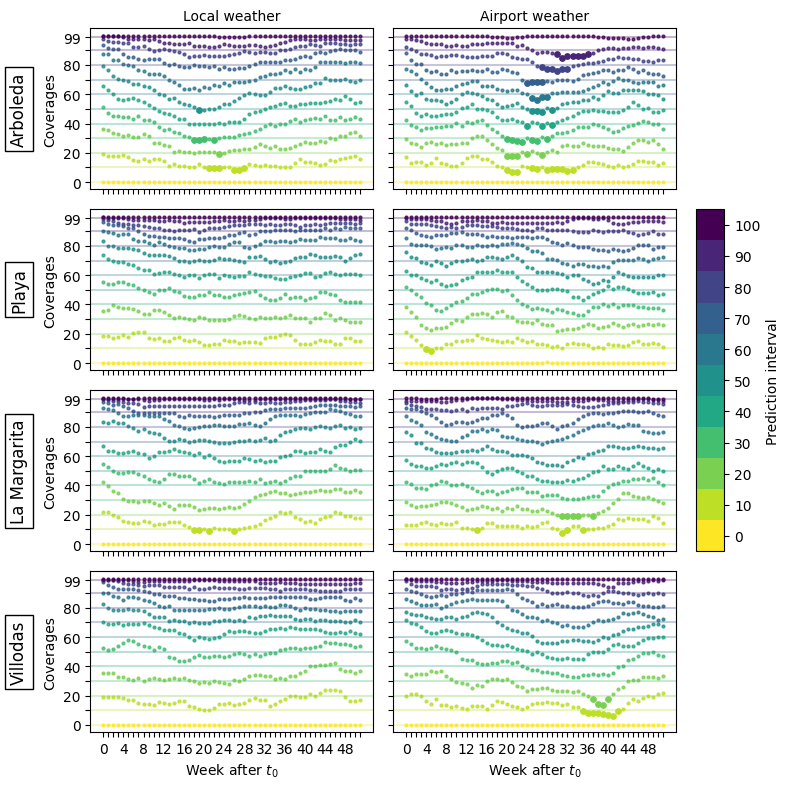

In [10]:
importlib.reload(gen_utils)
importlib.reload(forecast)

# Test airport weather compared to true weather and impact of Fourier smoothing
# Neural network predictions are always smoothed

weather_flags = ['site', 'airport']
FT_flags = [True]

weather_FT_flags = list(itertools.product(weather_flags, FT_flags))

cmap = plt.get_cmap('viridis')

sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']

#fig, axs = plt.subplots(4,2, sharex=True, sharey=True, figsize=(8,8))
fig = plt.figure(figsize=(8,8))
gs = mpl.gridspec.GridSpec(4, 3, width_ratios=(10,10,1), figure = fig)
rows = np.arange(0,4)

for site,row_idx in zip(sites,rows):
    cols = np.arange(0,2)
    for weather_FT_flag,col_idx in zip(weather_FT_flags,cols):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        weather_flag, FT_flag = weather_FT_flag

        coverage_fil_name = '{}/{}_{}_smoothed_coverages.csv'.format(coverages_path,site,weather_flag)
        if weather_flag=='site':
            title = 'Local weather'
        else:
            title = 'Airport weather'

        coverages = gen_utils.load_csv(coverage_fil_name)

        
        alpha_grouped = coverages.groupby(['alpha']).mean()
        
        for alpha in alpha_grouped.index:
            color = cmap(1-alpha)
            vals = 100*alpha_grouped[alpha_grouped.index==alpha].values[0]
            
            wiggle_level = 0.98
            good_idxs = np.where(vals>=100*wiggle_level*alpha)[0]
            bad_idxs = np.where(vals<100*wiggle_level*alpha)[0]
            
            wks = np.arange(0,len(vals))
            ax.axhline(y=alpha*100, xmin=0, xmax=len(vals), color=color, alpha=0.3)
            marker_size = 4
            ax.scatter(wks[good_idxs], vals[good_idxs], color=color, alpha=0.8, s=marker_size)
            ax.scatter(wks[bad_idxs], vals[bad_idxs], color=color, alpha=1, s=15)
        
        ax.set_yticks(100*alpha_grouped.index.values)
        ax.set_xticks(wks)

        if (row_idx == 0):
            ax.set_title(title, size='medium')

        if (col_idx % 2)==0:
            ax.set_ylabel('Coverages')
            ax.annotate(site.replace('_', ' '), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-7,0), bbox=dict(boxstyle="square", fc="white"), rotation = 90, xycoords = ax.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
            for k,label in zip(range(len(ax.yaxis.get_ticklabels())), ax.yaxis.get_ticklabels()):
                if not( (k % 2) == 0 ):
                    label.set_visible(False)
        else:
            ax.yaxis.set_ticklabels([])

        if row_idx>2:
            ax.set_xlabel('Week after $t_0$')
            for k,label in zip(range(len(ax.xaxis.get_ticklabels())), ax.xaxis.get_ticklabels()):
                if not ( (k % 4) == 0 ):
                    label.set_visible(False)
        else:
            ax.xaxis.set_ticklabels([])

cmap = plt.get_cmap('viridis_r')
ax = fig.add_subplot(gs[1:3,2])
bounds = np.linspace(0,110,12)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, ticks=bounds, boundaries=bounds)
cb.ax.set_ylabel('Prediction interval')

locs = np.arange(5,106,step=10)
labels = ['{}'.format(i) for i in range(0,101,10)]
ax.set_yticks(locs)
ax.set_yticklabels(labels)

fig.tight_layout()
fig.savefig('{}/site_weather_coverages.png'.format(metric_figures_path), dpi=300, bbox_inches='tight')

